# Wess Zumino 

## N=1 in 1+1

The Hamiltonian with a central difference for the derivative is given by 

\begin{align}
    H=\sum_n&\left[ \frac{p_n^2}{2a} + \frac{a}{2}\left(\frac{\phi_{n+1}-\phi_{n-1}}{2a}\right)^2+\frac{a}{2}V(\phi_n)^2
            +aV(\phi_n)\frac{\phi_{n+1}-\phi_{n-1}}{2a} \right. \nonumber \\
            &\left.+(-1)^nV'(\phi_n)\left(\chi_n^{\dagger}\chi_n-\frac{1}{2}\right)
            +\frac{1}{2a}\left(\chi_n^{\dagger}\chi_{n+1}+\chi_{n+1}^{\dagger}\chi_n\right) \right],
\end{align}

In [1]:
import sympy as sp
from ham_to_sparse_matrix import *
from constants import *
import scipy.sparse.linalg

In [2]:
bosonNI=sp.expand( pn**2/(2*aLat) + (aLat/2)*((qnP1-qnM1)/(2*aLat))**2 )
bosonI=sp.expand( (aLat/2)*V(qn)**2 + aLat*V(qn)*(qnP1-qnM1)/(4*aLat) + aLat*(qnP1-qnM1)*V(qn)/(4*aLat) )
fermionNI=sp.expand( -(xdnP1*xn+xdn*xnP1)/(2*aLat) )
fermionI=sp.expand( sp.diff(V(qn),qn)*(xdn*xn-(1/2)) )

In [3]:
bosonNI+bosonI

a*V(q_{n})**2/2 + q_{n+1}*V(q_{n})/4 - q_{n-1}*V(q_{n})/4 + V(q_{n})*q_{n+1}/4 - V(q_{n})*q_{n-1}/4 + p_{n}**2/(2*a) - q_{n+1}*q_{n-1}/(8*a) + q_{n+1}**2/(8*a) - q_{n-1}*q_{n+1}/(8*a) + q_{n-1}**2/(8*a)

In [4]:
fermionNI + fermionI

-0.5*Derivative(V(q_{n}), q_{n}) + Derivative(V(q_{n}), q_{n})*\chi^{\dagger}_{n}*\chi_{n} - \chi^{\dagger}_{n+1}*\chi_{n}/(2*a) - \chi^{\dagger}_{n}*\chi_{n+1}/(2*a)

In [5]:
N=3
aVal=1

# depends on finite-difference method
qs=[SiteSymbol('q',str(i)) for i in range(-1,N+1,1)]
# maybe make qs a normal site list
# and make an extra boundaryQs list for q[-1], q[N]
# counting would be normal computer science way for rest of code.

ps=[SiteSymbol('p',str(i)) for i in range(-1,N+1,1)] # don't really need extras
aops=[SiteSymbol('a',str(i)) for i in range(-1,N+1,1)]
adags=[SiteSymbol('a^{\dagger}',str(i)) for i in range(-1,N+1,1)]
xs=[SiteSymbol('\chi',str(i)) for i in range(-1,N+1,1)]
xdags=[SiteSymbol('\chi^{\dagger}',str(i)) for i in range(-1,N+1,1)]

# note this is exactly hardcoded for this finite difference method.
bcType = 'dirichlet'
boundaryConditions = {}
if bcType == 'periodic':
    boundaryConditions = {qs[0]: qs[N], qs[N+1]: qs[1],
                          xs[0]: -xs[N], xs[N+1]: -xs[1], 
                          xdags[0]: -xdags[N],  xdags[N+1]: -xdags[1]
                         }
    
elif bcType == 'dirichlet':
    boundaryConditions = { qs[0]: 0, qs[N+1]: 0,
                          xs[0]: 0, xs[N+1]: 0,
                          xdags[0]: 0, xdags[N+1]:0
                         }

In [6]:
totHam=bosonNI+bosonI+fermionNI+fermionI
totHam

a*V(q_{n})**2/2 + q_{n+1}*V(q_{n})/4 - q_{n-1}*V(q_{n})/4 + V(q_{n})*q_{n+1}/4 - V(q_{n})*q_{n-1}/4 - 0.5*Derivative(V(q_{n}), q_{n}) + Derivative(V(q_{n}), q_{n})*\chi^{\dagger}_{n}*\chi_{n} - \chi^{\dagger}_{n+1}*\chi_{n}/(2*a) - \chi^{\dagger}_{n}*\chi_{n+1}/(2*a) + p_{n}**2/(2*a) - q_{n+1}*q_{n-1}/(8*a) + q_{n+1}**2/(8*a) - q_{n-1}*q_{n+1}/(8*a) + q_{n-1}**2/(8*a)

In [7]:
ham=0

c=-0.4
c2=1

for i in range(1,N+1):
    ham+=(bosonNI+bosonI+fermionNI).subs({
        pn: ps[i],
        qn: qs[i], qnP1: qs[i+1], qnM1: qs[i-1],
        xn: xs[i], xnP1: xs[i+1],
        xdn: xdags[i], xdnP1: xdags[i+1]
    }).subs(boundaryConditions)
    
# ham.subs(boundaryConditions).doit() # this doesn't work?


def potential(n):
    return c + c2*qs[n]*qs[n]

potentialSubs={}
for n in range(1,N+1):
    potentialSubs[V(qs[n])]=potential(n)

ham=sp.simplify(ham.subs(potentialSubs).subs(aLat,aVal))

for i in range(1,N+1):
    if i%2==0:
        ham+=sp.simplify(fermionI.subs({qn: qs[i], xn: xs[i], xdn: xdags[i]}).subs(potentialSubs))
    else:
        ham-=sp.simplify(fermionI.subs({qn: qs[i], xn: xs[i], xdn: xdags[i]}).subs(potentialSubs))
ham=sp.simplify(ham.subs(aLat,aVal))
ham

(1.92 - 4*\chi^{\dagger}_{0}*\chi_{1} - 4*\chi^{\dagger}_{1}*\chi_{0} - 4*\chi^{\dagger}_{1}*\chi_{2} - 4*\chi^{\dagger}_{2}*\chi_{1} + 4*p_{0}**2 + 4*p_{1}**2 + 4*p_{2}**2 + 9.6*q_{0} - 16*q_{0}*\chi^{\dagger}_{0}*\chi_{0} - 2*q_{0}*q_{1}**2 - q_{0}*q_{2} - 2.2*q_{0}**2 + 2*q_{0}**2*q_{1} + 4*q_{0}**4 - 8.0*q_{1} + 16*q_{1}*\chi^{\dagger}_{1}*\chi_{1} + 2*q_{1}*q_{0}**2 - 2*q_{1}*q_{2}**2 - 1.2*q_{1}**2 - 2*q_{1}**2*q_{0} + 2*q_{1}**2*q_{2} + 4*q_{1}**4 + 6.4*q_{2} - 16*q_{2}*\chi^{\dagger}_{2}*\chi_{2} - q_{2}*q_{0} + 2*q_{2}*q_{1}**2 - 2.2*q_{2}**2 - 2*q_{2}**2*q_{1} + 4*q_{2}**4)/8

In [8]:
m=1

HOdofSubs = {}
#offset because of BC
for i in range(1,N+1):
    HOdofSubs[qs[i]] = 0.5*sp.sqrt(2/m)*(aops[i] + adags[i])
    HOdofSubs[ps[i]] = complex(0,1)*sp.sqrt(2*m)*(adags[i] - aops[i])/2 

hoHam=sp.expand(ham.subs(HOdofSubs))
hoHam=sp.nsimplify(hoHam,tolerance=1e-8)
hoHam

6/25 - \chi^{\dagger}_{0}*\chi_{1}/2 - \chi^{\dagger}_{1}*\chi_{0}/2 - \chi^{\dagger}_{1}*\chi_{2}/2 - \chi^{\dagger}_{2}*\chi_{1}/2 + 70053979*a^{\dagger}_{0}/82559406 - 131836323*a^{\dagger}_{0}*\chi^{\dagger}_{0}*\chi_{0}/93222358 - 3998607*a^{\dagger}_{0}*a^{\dagger}_{1}*a_{1}/45239074 - 3998607*a^{\dagger}_{0}*a^{\dagger}_{1}**2/45239074 - a^{\dagger}_{0}*a^{\dagger}_{2}/16 + 9*a^{\dagger}_{0}*a_{0}/80 + a^{\dagger}_{0}*a_{0}*a^{\dagger}_{0}*a_{0}/8 + a^{\dagger}_{0}*a_{0}*a^{\dagger}_{0}**2/8 + 3998607*a^{\dagger}_{0}*a_{0}*a^{\dagger}_{1}/45239074 + 3998607*a^{\dagger}_{0}*a_{0}*a_{1}/45239074 + a^{\dagger}_{0}*a_{0}**2*a^{\dagger}_{0}/8 + a^{\dagger}_{0}*a_{0}**3/8 - 3998607*a^{\dagger}_{0}*a_{1}*a^{\dagger}_{1}/45239074 - 3998607*a^{\dagger}_{0}*a_{1}**2/45239074 - a^{\dagger}_{0}*a_{2}/16 - 31*a^{\dagger}_{0}**2/80 + 3998607*a^{\dagger}_{0}**2*a^{\dagger}_{1}/45239074 + a^{\dagger}_{0}**2*a_{0}*a^{\dagger}_{0}/8 + a^{\dagger}_{0}**2*a_{0}**2/8 + 3998607*a^{\dagger}_{0}**2*a_{

In [9]:
e0raw=[]

for cutoff in [2,3,4,5,6,7,8,9,10]:
    t=Timer('toHam')
    t.start()
    hamMat=convert_to_matrix(hoHam,cutoff,N,aops,adags,xs,xdags)
    t.stop()
    
    t=Timer('evals')
    t.start()
    ens=scipy.sparse.linalg.eigs(hamMat,k=10,which='SM')[0]
    t.stop()
    e0raw.append(ens[0])
    
    print("Lambda = ",cutoff)
    print(ens)
    print()

/home/chrisculver/miniconda3/envs/QuantumComputing/lib/python3.9/site-packages/scipy/sparse/_sputils.py:114: UserWarning: object dtype is not supported by sparse matrices
  warnings.warn("object dtype is not supported by sparse matrices")


toHam timer took: 1.7325 seconds
evals timer took: 0.0132 seconds
Lambda =  2
[-0.17632036-6.6743855e-10j -0.0348989 +1.0633509e-08j
 -0.17632155-9.3214130e-09j -0.03489865-1.4168811e-08j
  0.01596822+6.2864274e-09j  0.01596798-1.5536131e-08j
  0.18289515+1.2291150e-09j  0.18289341+5.9822298e-09j
  0.18289465+3.9034411e-09j  0.18289408-2.2814550e-08j]

toHam timer took: 2.9846 seconds
evals timer took: 0.0278 seconds
Lambda =  3
[-0.0074323 +2.0544904e-09j -0.3462941 -4.4703484e-08j
 -0.34629384+8.3236955e-09j -0.00743228-1.3033094e-08j
  0.30618706-3.0522955e-08j  0.306184  -5.5883422e-09j
  0.25056335+7.1247639e-09j  0.2505606 -7.1031989e-09j
  0.2538165 -9.8454080e-09j  0.2538152 -1.4657708e-08j]

toHam timer took: 5.5606 seconds
evals timer took: 0.0238 seconds
Lambda =  4
[-0.03754034-2.8288923e-08j -0.03753893+2.3443931e-08j
  0.28213334-2.4213691e-08j  0.28213274+2.0765583e-08j
  0.70874393-1.5458081e-09j  0.5111249 +1.7259348e-08j
  0.5111224 +1.4800307e-08j  0.7087427 +3.10473

In [10]:
e0raw

[(-0.17632036-6.6743855e-10j),
 (-0.007432304+2.0544904e-09j),
 (-0.037540335-2.8288923e-08j),
 (-0.16539337-2.0372681e-08j),
 (0.00686349-2.1464075e-10j),
 (0.14828974+2.5518239e-07j),
 (0.12079301+3.1147472e-08j),
 (0.15858257-5.122274e-08j),
 (0.15672453-2.8312206e-07j)]

In [13]:
e0raw=[(-0.17632036-6.6743855e-10j),
 (-0.007432304+2.0544904e-09j),
 (-0.037540335-2.8288923e-08j),
 (-0.16539337-2.0372681e-08j),
 (0.00686349-2.1464075e-10j),
 (0.14828974+2.5518239e-07j),
 (0.12079301+3.1147472e-08j),
 (0.15858257-5.122274e-08j),
 (0.15672453-2.8312206e-07j)]

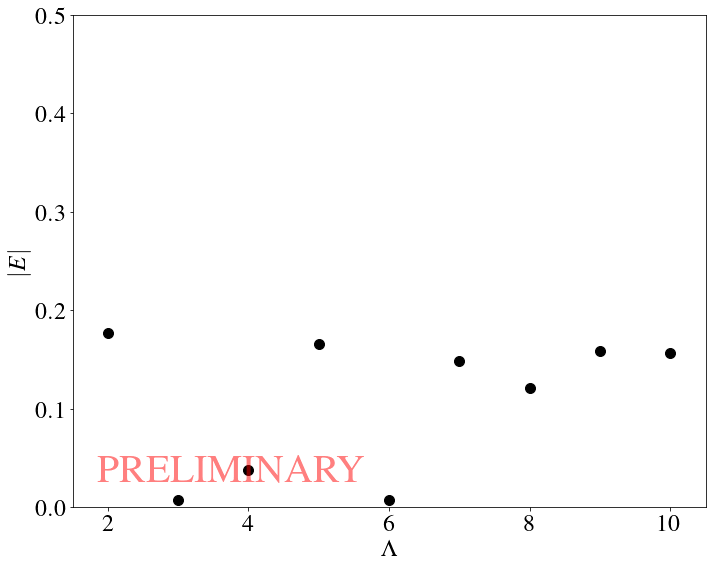

In [14]:
import matplotlib.pyplot as plt

import matplotlib 
#matplotlib.use("Agg")
plt.style.use("paper.mplstyle")

fig, ax = plt.subplots()

plt.scatter([x for x in range(2,11)],[abs(en.real) for en in e0raw], c='black')

plt.xlabel('$\\Lambda$')
plt.ylabel('$|E|$')

plt.xlim(1.5,10.5)
plt.ylim(0,0.5)
#plt.yscale('log')

ax.text(0.25, 0.07, 'PRELIMINARY', transform=ax.transAxes,
        fontsize=40, color='red', alpha=0.5,
        ha='center', va='center', rotation='0')

plt.savefig('PLOTS/WZ_3site_vq2_cm0p1.pdf',bbox_inches='tight')